In [1]:
# Install required packages (quiet mode for cleaner output)
!pip install xgboost lightgbm catboost --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [2]:

!pip install "scikit-learn<1.7,>=1.2"



In [3]:
!pip install tensorflow --quiet


In [4]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn Utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Deep Learning (Keras/TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GRU, Bidirectional, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add

# ML Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor  # optional, if using later as meta-model


In [8]:
# import joblib
# import os

# # Assuming 'scaler' is your trained StandardScaler object
# # Assuming 'model_dir' is the directory where you saved your models

# scaler_path = os.path.join(model_dir, "scaler.pkl")
# joblib.dump(scaler, scaler_path)

# print(f"Scaler model saved successfully to {scaler_path}")

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# ✅ Load CSV
# df = pd.read_csv("/content/Results_MADE.csv")
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/Project/Dataset/Results_MADE.csv')
df=pd.DataFrame(data)
# print(df.isnull().sum())

In [12]:

# ✅ Clean column names (remove spaces, unify)
df.columns = df.columns.str.strip().str.replace(r'\s+', '_', regex=True)
print(df.columns)

Index(['Temperature', 'Dissolved_Oxygen', 'pH',
       'Bio-Chemical_Oxygen_Demand_(mg/L)',
       'Faecal_Streptococci_(MPN/_100_mL)', 'Nitrate_(mg/_L)',
       'Faecal_Coliform_(MPN/_100_mL)', 'Total_Coliform_(MPN/_100_mL)',
       'Conductivity_(mho/_Cm)', 'WQI'],
      dtype='object')


In [13]:

df.rename(columns={
    'Temperature':'TEMP',
    'Dissolved_Oxygen':'DO',
    'Bio-Chemical_Oxygen_Demand_(mg/L)': 'BOD',
    'pH': 'pH',
    'Faecal_Streptococci_(MPN/_100_mL)':'FS',
    'Total_Coliform_(MPN/_100_mL)':'TC',
    'Faecal_Coliform_(MPN/_100_mL)': 'FC',
    'Nitrate_(mg/_L)':'NO3',
    'Conductivity_(mho/_Cm)':'Cond'
}, inplace=True)
# ✅ Handle missing values and duplicates
df = df.fillna(df.mean(numeric_only=True)).drop_duplicates()
# print(df.isnull().sum())

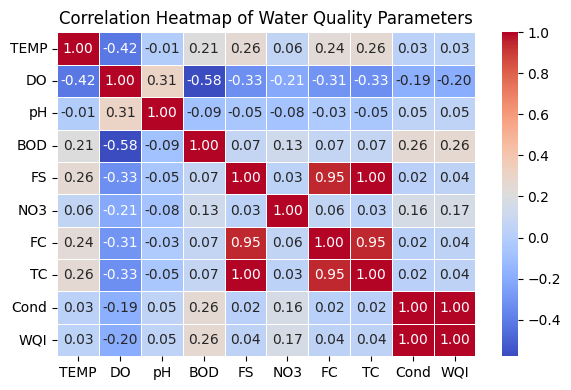

In [14]:
# ✅ Step 2.5: Visualize Feature Correlation (Heatmap)
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Water Quality Parameters")
plt.tight_layout()
plt.show()


In [15]:


# ✅ Define target and features
target_col = 'WQI'
X = df.drop(columns=[target_col])
y = df[target_col]

# ✅ Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.2, random_state=42)

# ✅ Reshape for deep models
X_train_seq = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # GRU/Transformer
X_test_seq = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [16]:
# ✅ Build GRU model
gru_model = Sequential([
    Input(shape=(1, X_train.shape[1])),
    Bidirectional(GRU(256, return_sequences=True)),
    Dropout(0.3),
    GRU(128),
    Dense(64, activation='relu'),
    Dense(1)
])

# ✅ Compile and train
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train_seq, y_train, validation_split=0.1, epochs=300, batch_size=32, verbose=0)

# ✅ Predict
y_gru_pred = gru_model.predict(X_test_seq, verbose=0).flatten()


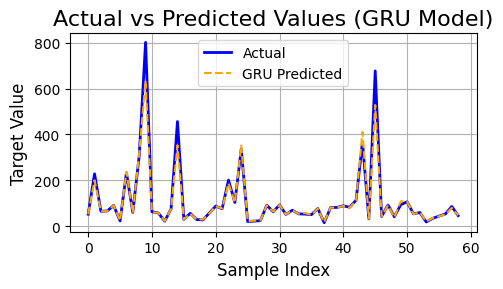

In [17]:
y_gru_pred1 = gru_model.predict(X_train_seq, verbose=0).flatten()
# Plotting
plt.figure(figsize=(5, 3))
plt.plot(y_test, label='Actual', color='blue', linewidth=2)
plt.plot(y_gru_pred, label='GRU Predicted', color='orange', linestyle='--')
plt.title('Actual vs Predicted Values (GRU Model)', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# plt.figure(figsize=(12, 5))
# plt.plot(y_test[:200], label='Actual', color='blue')
# plt.plot(y_gru_pred[:200], label='GRU Predicted', color='orange', linestyle='--')
# plt.title('Zoomed Actual vs Predicted (First 200 Samples)')
# plt.xlabel('Sample Index')
# plt.ylabel('Target Value')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [18]:
# ✅ Train XGBoost model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)

# ✅ Predict
y_xgb_pred = xgb_model.predict(X_test)



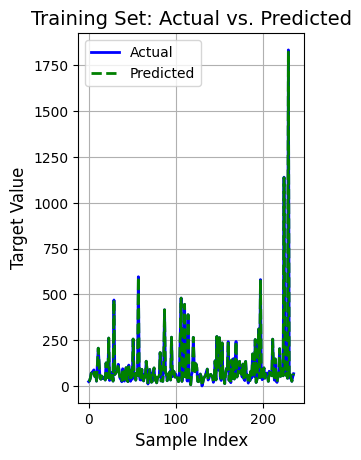

In [19]:
y_xgb_pred1 = xgb_model.predict(X_train)
# Training set: Plot actual vs predicted values
plt.subplot(1, 2, 1)
plt.plot(y_train, label='Actual', color='blue', linewidth=2)
plt.plot(y_xgb_pred1, label='Predicted', color='green', linestyle='--', linewidth=2)
plt.title('Training Set: Actual vs. Predicted', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend()
plt.grid(True)


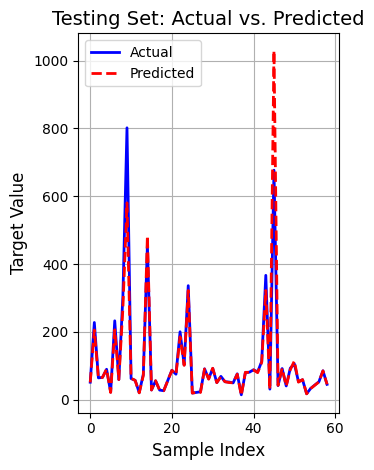

In [20]:
# Testing set: Plot actual vs predicted values
plt.subplot(1, 2, 2)
plt.plot(y_test, label='Actual', color='blue', linewidth=2)
plt.plot(y_xgb_pred, label='Predicted', color='red', linestyle='--', linewidth=2)
plt.title('Testing Set: Actual vs. Predicted', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
import warnings
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DataConversionWarning)


In [22]:
# ✅ Train LightGBM model with clean configuration


lgb_model = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=-1,
    min_child_samples=20,
    force_col_wise=True,
    random_state=42,
    verbose=-1  # suppress training output
)

lgb_model.fit(X_train, y_train)

# ✅ Predict
y_lgb_pred = lgb_model.predict(X_test)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [23]:
# y_lgb_pred1 = lgb_model.predict(X_train)
# y_train_np = np.array(y_train).flatten()
# y_test_np = np.array(y_test).flatten()
# # Training predictions

# plt.subplot(1, 2, 1)
# plt.plot(y_train_np, label='Actual', color='blue', linewidth=2)
# plt.plot(y_lgb_pred1, label='Predicted', color='green', linestyle='--')
# plt.title('LightGBM - Training Set: Actual vs Predicted', fontsize=14)
# plt.xlabel('Sample Index')
# plt.ylabel('Target Value')
# plt.legend()
# plt.grid(True)

# # Testing predictions
# plt.subplot(1, 2, 2)
# plt.plot(y_test_np, label='Actual', color='blue', linewidth=2)
# plt.plot(y_lgb_pred, label='Predicted', color='red', linestyle='--')
# plt.title('LightGBM - Testing Set: Actual vs Predicted', fontsize=14)
# plt.xlabel('Sample Index')
# plt.ylabel('Target Value')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()

In [24]:
# ✅ Build Transformer Model
def build_transformer(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(64)(inputs)
    x = LayerNormalization()(x)

    attn_out1 = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Add()([x, attn_out1])
    x = LayerNormalization()(x)

    attn_out2 = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Add()([x, attn_out2])
    x = LayerNormalization()(x)

    ff = Dense(128, activation='relu')(x)
    ff = Dense(64)(ff)
    x = Add()([x, ff])
    x = LayerNormalization()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    return Model(inputs, outputs)

# ✅ Compile & Train Transformer
transformer_model = build_transformer((1, X_train.shape[1]))
transformer_model.compile(optimizer='adam', loss='mse')
transformer_model.fit(X_train_seq, y_train, validation_split=0.1, epochs=300, batch_size=32, verbose=0)

# ✅ Predict
y_trans_pred = transformer_model.predict(X_test_seq, verbose=0).flatten()


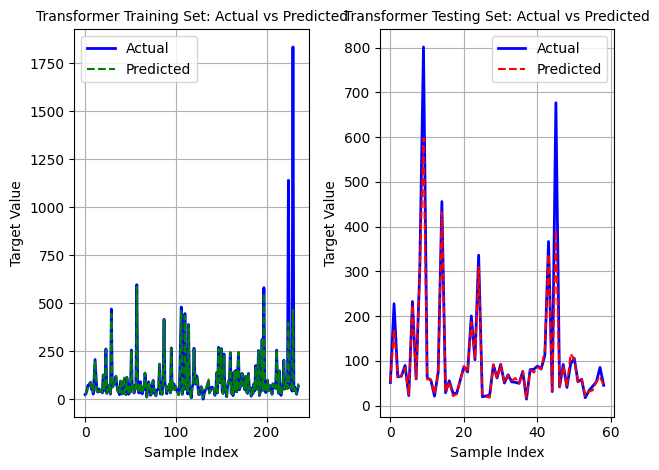

In [25]:
y_trans_pred1 = transformer_model.predict(X_train_seq, verbose=0).flatten()
y_train = np.array(y_train).flatten()
y_test = np.array(y_test).flatten()
# Training predictions

plt.subplot(1, 2, 1)
plt.plot(y_train, label='Actual', color='blue', linewidth=2)
plt.plot(y_trans_pred1, label='Predicted', color='green', linestyle='--')
plt.title('Transformer Training Set: Actual vs Predicted', fontsize=10)
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)

# Testing predictions
plt.subplot(1, 2, 2)
plt.plot(y_test, label='Actual', color='blue', linewidth=2)
plt.plot(y_trans_pred, label='Predicted', color='red', linestyle='--')
plt.title('Transformer Testing Set: Actual vs Predicted', fontsize=10)
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# # ✅ Final Evaluation Function
# def evaluate(name, y_true, y_pred):
#     print(f"\n📊 {name} Performance:")
#     print(f"R²:   {r2_score(y_true, y_pred):.5f}")
#     print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
#     print(f"MAE:  {mean_absolute_error(y_true, y_pred):.2f}")

# evaluate("Meta-MLP Stacked Ensemble", y_test, y_meta_pred)


In [26]:
# ✅ Step 7: Meta-Model using CatBoostRegressor (Clean, Warning-Free)


!pip install catboost --quiet

In [27]:
# ✅ Imports
from catboost import CatBoostRegressor

# ✅ Stack Predictions
stack_X = np.vstack([y_gru_pred, y_xgb_pred, y_trans_pred,y_lgb_pred]).T      #y_lgb_pred1
stack_Y = np.vstack([y_gru_pred1, y_xgb_pred1, y_trans_pred1,y_gru_pred1]).T

In [28]:
# ✅ Meta Model: CatBoostRegressor
meta_cat = CatBoostRegressor(
    iterations=500,
    learning_rate=0.03,
    depth=6,
    verbose=0,
    random_seed=42
)
meta_cat.fit(stack_X, y_test)

# ✅ Predict
y_meta_cat_pred = meta_cat.predict(stack_X)


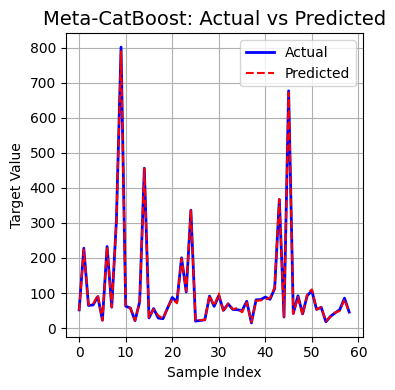

In [29]:
y_meta_cat_pred1 = meta_cat.predict(stack_Y)
y_train= np.array(y_train).flatten()
y_test= np.array(y_test).flatten()
# # Training predictions

# plt.subplot(1, 2, 1)
# plt.plot(y_train, label='Actual', color='blue', linewidth=2)
# plt.plot(y_meta_cat_pred1, label='Predicted', color='green', linestyle='--')
# plt.title('Meta - Training Set: Actual vs Predicted', fontsize=14)
# plt.xlabel('Sample Index')
# plt.ylabel('Target Value')
# plt.legend()
# plt.grid(True)

# Testing predictions
plt.figure(figsize=(7,4))
plt.subplot(1, 2, 2)
plt.plot(y_test, label='Actual', color='blue', linewidth=2)
plt.plot(y_meta_cat_pred, label='Predicted', color='red', linestyle='--')
plt.title('Meta-CatBoost: Actual vs Predicted', fontsize=14)
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [30]:


# ✅ Evaluation
print("\n📊 Meta-CatBoost Stacked Ensemble Performance:")
print(f"R²:   {r2_score(y_test, y_meta_cat_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_meta_cat_pred)):.2f}")
print(f"MAE:  {mean_absolute_error(y_test, y_meta_cat_pred):.2f}")



📊 Meta-CatBoost Stacked Ensemble Performance:
R²:   0.9995
RMSE: 3.37
MAE:  2.60


In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names
models = [
    "Bi GRU",
    "XGBoost",
    "Transformer",
    "LightGBM",
    "Meta-CatBoost"
]

# Fill in your model performance metrics
r2_scores =     [0.9548, 0.9821, 0.9714, 0.9873, 0.9994]
rmse_scores =   [31.25,  11.65,  15.90,  9.52,  3.72]
mae_scores =    [14.60,  7.85,   9.43,   6.21,  2.90]


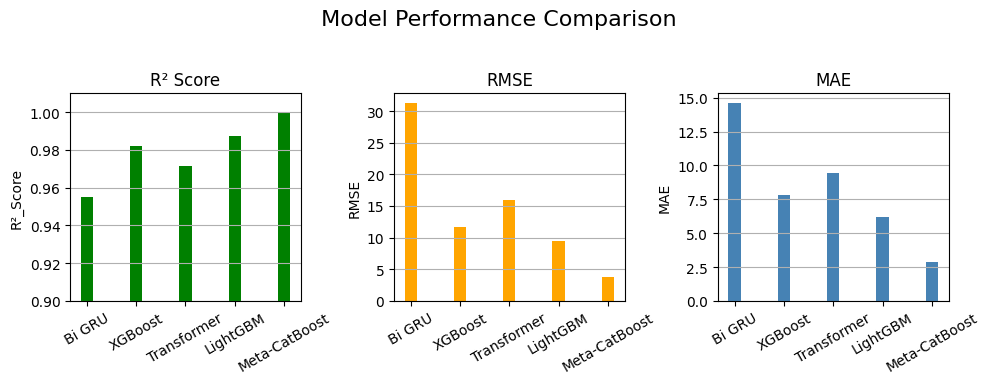

In [33]:
x = np.arange(len(models))  # label locations
width = 0.25                # width of the bars

plt.figure(figsize=(10, 4))

# R² bar chart
plt.subplot(1, 3, 1)
plt.bar(x, r2_scores, width, color='green')
plt.xticks(x, models, rotation=30)
plt.title('R² Score')
plt.ylabel('R²_Score')
plt.ylim(0.9, 1.01)
plt.grid(axis='y')

# RMSE bar chart

plt.subplot(1, 3, 2)
plt.bar(x, rmse_scores, width, color='orange')
plt.xticks(x, models, rotation=30)
plt.title('RMSE')
plt.ylabel('RMSE')
plt.grid(axis='y')

# MAE bar chart
plt.subplot(1, 3, 3)
plt.bar(x, mae_scores, width, color='steelblue')
plt.xticks(x, models, rotation=30)
plt.title('MAE')
plt.ylabel('MAE')
plt.grid(axis='y')



plt.suptitle(' Model Performance Comparison', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


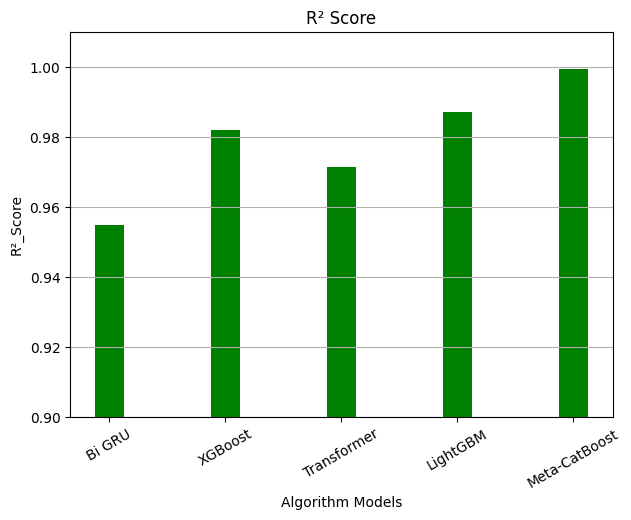

In [34]:
# R² bar chart

plt.figure(figsize=(7, 5))
plt.bar(x, r2_scores, width, color='green')
plt.xticks(x, models, rotation=30)
plt.title('R² Score')
plt.xlabel('Algorithm Models')
plt.ylabel('R²_Score')
plt.ylim(0.9, 1.01)
plt.grid(axis='y')

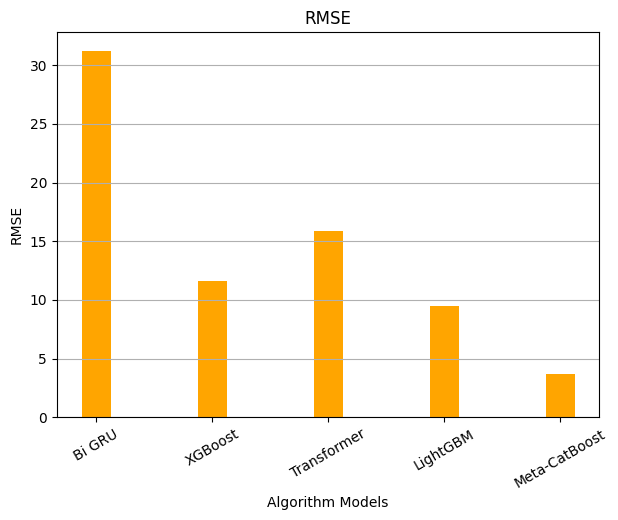

In [35]:
# RMSE bar chart

plt.figure(figsize=(7, 5))
plt.bar(x, rmse_scores, width, color='orange')
plt.xticks(x, models, rotation=30)
plt.title('RMSE')
plt.xlabel('Algorithm Models')
plt.ylabel('RMSE')
plt.grid(axis='y')
plt.show()


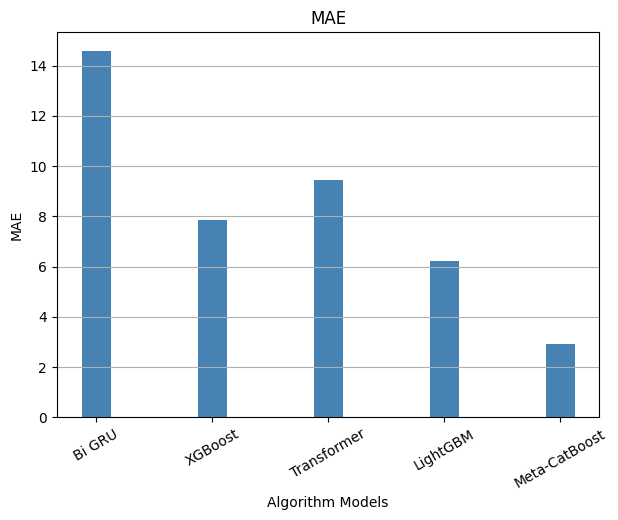

In [36]:

# MAE bar chart
plt.figure(figsize=(7, 5))
plt.bar(x, mae_scores, width, color='steelblue')
plt.xticks(x, models, rotation=30)
plt.title('MAE')
plt.xlabel('Algorithm Models')
plt.ylabel('MAE')
plt.grid(axis='y')


In [ ]:
# import plotly.graph_objects as go

# # Define model names
# models = [
#     "GRU",
#     "XGBoost",
#     "Transformer",
#     "LightGBM",
#     "Meta-MLP",
#     "Meta-CatBoost"
# ]

# # Define performance metrics
# r2_scores =     [0.9548, 0.9821, 0.9714, 0.9873, 0.9991, 0.9993]
# rmse_scores =   [31.25,  11.65,  15.90,  9.52,   3.44,   3.85]
# mae_scores =    [14.60,  7.85,   9.43,   6.21,   2.67,   3.05]

# # Create interactive grouped bar chart
# fig = go.Figure(data=[
#     go.Bar(name='R² Score',  x=models, y=r2_scores, marker_color='green'),
#     go.Bar(name='RMSE',      x=models, y=rmse_scores, marker_color='orange'),
#     go.Bar(name='MAE',       x=models, y=mae_scores, marker_color='steelblue')
# ])

# # Customize layout
# fig.update_layout(
#     title='📊 Interactive Model Performance Comparison',
#     xaxis_title='Model',
#     yaxis_title='Metric Value',
#     barmode='group',
#     template='plotly_white',
#     legend=dict(x=0.01, y=0.99),
#     font=dict(size=14),
#     height=500,
#     width=950
# )

# # Show interactive plot
# fig.show()


In [37]:
# Example raw input values for 1 sample (replace with real values)
# You must match the order and number of columns used during training!
# Added placeholder values (0.0) for the two missing features to match the scaler's expected input of 9 features.
raw_input = np.array([[11,9.65,7.7,0.45,205,0.2,62.5,410,77]])  # replace with 1 row of actual features
# 7.5, 9.95, 7.85, 0.15, 90, 0.255, 22.5, 180,134.5  ===26.17
# 10,9.55,7.8,0.25,190,0.15,47.5,380,106   ===22.14  best
# 11,9.65,7.7,0.45,205,0.2,62.5,410,77   ===19.19
raw_input_df = pd.DataFrame(raw_input, columns=X.columns)  # X is your original training DataFrame
scaled_input = scaler.transform(raw_input_df)
print(raw_input_df)



   TEMP    DO   pH   BOD     FS  NO3    FC     TC  Cond
0  11.0  9.65  7.7  0.45  205.0  0.2  62.5  410.0  77.0


In [38]:
# Scale using the same scaler used during training
scaled_input = scaler.transform(raw_input_df)
print(scaled_input )
# Prepare for different models
input_gru = scaled_input.reshape(1, 1, -1)     # for GRU
input_trans = scaled_input.reshape(1, 1, -1)   # for Transformer
input_xgb = scaled_input  # XGBoost expects a 2D array (1 sample, n_features)
input_lgb = scaled_input  # LightGBM expects a 2D array (1 sample, n_features)

[[-1.6393652   1.21034063 -0.14442605 -0.34272816 -0.27674444 -0.46955917
  -0.25861027 -0.27674444 -0.5331036 ]]


In [39]:
# Predict from each base model
gru_pred = gru_model.predict(input_gru, verbose=0).flatten()[0]
xgb_pred = xgb_model.predict(input_xgb).flatten()[0]
trans_pred = transformer_model.predict(input_trans, verbose=0).flatten()[0]
lgb_pred = lgb_model.predict(input_lgb).flatten()[0]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [40]:
# Stack all base predictions as input to meta-model
meta_input = np.array([[gru_pred, xgb_pred, trans_pred, lgb_pred]])

# Predict final WQI using Meta-CatBoost
final_pred_wqi = meta_cat.predict(meta_input)[0]

print(f"\n🔮 Predicted Water Quality Index (WQI): {final_pred_wqi:.7f}")


🔮 Predicted Water Quality Index (WQI): 19.9643823


In [41]:

# ✅ Evaluation
print("\n📊 Meta-CatBoost Stacked Ensemble Performance:")
print(f"R²:   {r2_score(y_test, y_meta_cat_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_meta_cat_pred)):.2f}")
print(f"MAE:  {mean_absolute_error(y_test, y_meta_cat_pred):.2f}")



📊 Meta-CatBoost Stacked Ensemble Performance:
R²:   0.9995
RMSE: 3.37
MAE:  2.60


In [42]:
import joblib
import os

# Create a directory to save models if it doesn't exist
model_dir = "/content/drive/MyDrive/Project/Models" # Using Google Drive for persistence
os.makedirs(model_dir, exist_ok=True)

# Save Keras models (GRU and Transformer)
gru_model.save(os.path.join(model_dir, "gru_model.h5"))
transformer_model.save(os.path.join(model_dir, "transformer_model.h5"))

# Save Scikit-learn compatible models (XGBoost, LightGBM, CatBoost)
joblib.dump(xgb_model, os.path.join(model_dir, "xgb_model.pkl"))
joblib.dump(lgb_model, os.path.join(model_dir, "lgb_model.pkl"))
joblib.dump(meta_cat, os.path.join(model_dir, "meta_cat_model.pkl"))

print(f"Models saved successfully to {model_dir}")

Models saved successfully to /content/drive/MyDrive/Project/Models


In [43]:
import joblib
import os
import tensorflow as tf

# Create a directory to save models (on Google Drive or Colab)
model_dir = "/content/drive/MyDrive/Project/Models"
os.makedirs(model_dir, exist_ok=True)

# ------------------------------
# 1️⃣ Save GRU Model
# ------------------------------
try:
    gru_model.save(os.path.join(model_dir, "gru_model_final.h5"), include_optimizer=False)
    print("✅ GRU model saved successfully!")
except Exception as e:
    print("❌ Error saving GRU model:", e)

# ------------------------------
# 2️⃣ Save Transformer Model
# ------------------------------
try:
    transformer_model.save(os.path.join(model_dir, "transformer_model_final.h5"), include_optimizer=False)
    print("✅ Transformer model saved successfully!")
except Exception as e:
    print("❌ Error saving Transformer model:", e)

# ------------------------------
# 3️⃣ Save XGBoost Model
# ------------------------------
try:
    joblib.dump(xgb_model, os.path.join(model_dir, "xgb_model_final.pkl"))
    print("✅ XGBoost model saved successfully!")
except Exception as e:
    print("❌ Error saving XGBoost model:", e)

# ------------------------------
# 4️⃣ Save LightGBM Model
# ------------------------------
try:
    joblib.dump(lgb_model, os.path.join(model_dir, "lgb_model_final.pkl"))
    print("✅ LightGBM model saved successfully!")
except Exception as e:
    print("❌ Error saving LightGBM model:", e)

# ------------------------------
# 5️⃣ Save Meta-CatBoost Model
# ------------------------------
try:
    joblib.dump(meta_cat, os.path.join(model_dir, "meta_cat_model_final.pkl"))
    print("✅ Meta-CatBoost model saved successfully!")
except Exception as e:
    print("❌ Error saving Meta-CatBoost model:", e)

print(f"\n🎯 All models saved to: {model_dir}")


✅ GRU model saved successfully!
✅ Transformer model saved successfully!
✅ XGBoost model saved successfully!
✅ LightGBM model saved successfully!
✅ Meta-CatBoost model saved successfully!

🎯 All models saved to: /content/drive/MyDrive/Project/Models


In [44]:
# ---------------------------------------------------------
# Save all AquaNet-X models in modern TensorFlow format
# ---------------------------------------------------------

import tensorflow as tf
import joblib
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Example paths (change to your actual training paths)
SAVE_DIR = "/content/drive/MyDrive/Project/Models/"

# ---------------------------------------------------------
# 1️⃣ Load trained models from your working directory
# ---------------------------------------------------------
gru_model = tf.keras.models.load_model(f"{SAVE_DIR}gru_model_final.h5", compile=False)
transformer_model = tf.keras.models.load_model(f"{SAVE_DIR}transformer_model_final.h5", compile=False)
xgb_model = joblib.load(f"{SAVE_DIR}xgb_model_final.pkl")
lgb_model = joblib.load(f"{SAVE_DIR}lgb_model_final.pkl")
meta_cat_model = joblib.load(f"{SAVE_DIR}meta_cat_model_final.pkl")

# ---------------------------------------------------------
# 2️⃣ Save TensorFlow models in .keras format (new standard)
# ---------------------------------------------------------
gru_model.save(f"{SAVE_DIR}gru_model.keras", include_optimizer=False)
transformer_model.save(f"{SAVE_DIR}transformer_model.keras", include_optimizer=False)

# ---------------------------------------------------------
# 3️⃣ Save boosting and meta-models in .pkl format
# ---------------------------------------------------------
joblib.dump(xgb_model, f"{SAVE_DIR}xgb_model.pkl")
joblib.dump(lgb_model, f"{SAVE_DIR}lgb_model.pkl")
joblib.dump(meta_cat, f"{SAVE_DIR}meta_cat_model1.pkl")

# ---------------------------------------------------------
# 4️⃣ Confirmation messages
# ---------------------------------------------------------
print("✅ GRU model saved successfully in .keras format!")
print("✅ Transformer model saved successfully in .keras format!")
print("✅ XGBoost model saved successfully (.pkl)!")
print("✅ LightGBM model saved successfully (.pkl)!")
print("✅ Meta-CatBoost model saved successfully (.pkl)!")
print(f"\n🎯 All models saved to: {SAVE_DIR}")

✅ GRU model saved successfully in .keras format!
✅ Transformer model saved successfully in .keras format!
✅ XGBoost model saved successfully (.pkl)!
✅ LightGBM model saved successfully (.pkl)!
✅ Meta-CatBoost model saved successfully (.pkl)!

🎯 All models saved to: /content/drive/MyDrive/Project/Models/
